In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import sys
import time
import shutil
import PIL

tf.__version__

'2.15.0'

### 이미지넷에 사용됐던 CNN layers를 사용해보자

## Usage `VGG16`
* [code link](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py)
* [document link](https://keras.io/applications/#vgg16)

```python
def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          **kwargs):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)`
            (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 input channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
```

In [ ]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150, 150, 3)) #224, 224, 3
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### VGG를 이용한 모델 구성

In [ ]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 16813381 (64.14 MB)
Trainable params: 2098693 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


* 학습할 파라미터를 지정해준다

In [ ]:
# assign conv1_1 and dense1 weight to compare itself after training some steps
for var in model.variables:
  #print(var.name)
  if var.name == 'block1_conv1/kernel:0':
    conv1_1_w = var
  if var.name == 'dense/kernel:0':
    dense_w = var

In [ ]:
print(conv1_1_w)
print(dense_w)

<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355

### 모델 학습 파라미터 지정
* 이미 학습된 CNN layer의 파라미터는 학습이 되지않도록 설정해야한다.

In [ ]:
# Freeze vgg16 conv base part (means that trainable option is False)
for layer in model.layers:
  if layer.name == 'vgg16':
    layer.trainable = False
  print("variable name: {}, trainable: {}".format(layer.name, layer.trainable))

variable name: vgg16, trainable: False
variable name: flatten, trainable: True
variable name: dense, trainable: True
variable name: dense_1, trainable: True


### 테스트용 데이터셋 다운로드
* 꽃 이미지 데이터셋

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


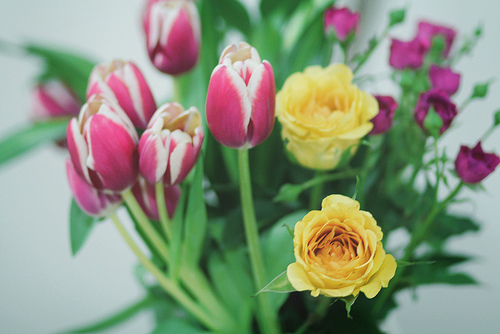

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
batch_size = 32
img_height = 150
img_width = 150
max_epochs = 10

In [ ]:
 train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
 val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 데이터 전처리 파트
* 모델 데이터에 맞도록 데이터를 0~1 사이 값으로 Normalization

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
 normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

### 모델 학습

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits 마지막 레이어의 activation 여부
              metrics=['accuracy'])

### keras callback 함수

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping],
    epochs=max_epochs
)

In [ ]:
print(history.history.keys())
len_res = len(history.history['accuracy'])
print(len_res)

In [ ]:
# Compare weights between before and after training some steps
for var in model.variables:
  #print(var.name)
  if var.name == 'block1_conv1/kernel:0':
    conv1_1_w_1 = var
  if var.name == 'dense/kernel:0':
    dense_w_1 = var

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len_res)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history = model.evaluate(val_ds)

In [ ]:
# loss
print("loss value: {:.3f}".format(history[0]))
# accuracy
print("accuracy value: {:.3f}".format(history[1]))